# RNNs for Timeseries Forecasting

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/ok-transformer/blob/master/docs/nb/tensorflow/05-tensorflow-cnn.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/ok-transformer?style=social)](https://github.com/particle1331/ok-transformer)

```text
𝗔𝘁𝘁𝗿𝗶𝗯𝘂𝘁𝗶𝗼𝗻: Notes for Chapter 10: Deep learning for timeseries of F. Chollet's Deep Learning with Python, 2nd Edition (2021).
```

---

## Introduction

Unlike the types of data we have encountered so far, working with timeseries involves understanding the **dynamics of a system**: periodic cycles, trends over time, regular regime, and sudden spikes. The most common timeseries-related task is forecasting: predicting what will happen next in a series. Although there are a wide range of tasks related to timeseries data such as classification, event detection, and anomaly detection.

Working with timeseries typically requires a wide range of domain-specific data representation techniques. Fourier analysis (or the related Mel-frequency analysis) and other domain-specific representations can be useful as a form of feature engineering for data that is primarily characterized by its cycles and oscillations. In this notebook, we will see that densely connected and convolutional networks are not well-equipped at dealing with forecasting timeseries datasets (or variable-length sequential data in general). Instead, we will see that a different kind of architecture called **recurrent neural networks** (RNNs) really shines on this type of problem.

In [1]:
import re
import os
import random as pyrandom
import warnings
import collections
from pathlib import Path

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

import tensorflow as tf
import tensorflow.keras as kr


def tf_enable_determinism(seed=None):
    # https://blog.tensorflow.org/2022/05/whats-new-in-tensorflow-29.html
    if seed is not None:
        tf.keras.utils.set_random_seed(seed)            # py, np, and tf
        tf.config.experimental.enable_op_determinism()  # tensorflow op (slower!)


DATASET_DIR = Path("./data").absolute()
RANDOM_SEED = 0

warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats('svg')
tf_enable_determinism(seed=RANDOM_SEED)

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.9.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Temperature forecasting

Throughout this section, we look at the fairly challenging problem of predicting the temperature 24 hours in the future, given a timeseries of hourly measurements of quantities such as atmospheric pressure and humidity, recorded over the
recent past by a set of sensors on the roof of a building. More precisely, a weather station at the Max Planck Institute for Biogeochemistry in Jena, Germany.

In [2]:
# !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
# !unzip "jena_climate_2009_2016.csv.zip" -d data -x "__MACOSX/*" && trash "jena_climate_2009_2016.csv.zip" -

In [3]:
file_path = DATASET_DIR / "jena_climate_2009_2016.csv"
raw_data = pd.read_csv(file_path)
raw_data['Date Time'] = pd.to_datetime(raw_data['Date Time'], format='%d.%m.%Y %H:%M:%S')
raw_data = raw_data.sort_values('Date Time').set_index('Date Time')

print(raw_data.shape)
raw_data.head()

(420451, 14)


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


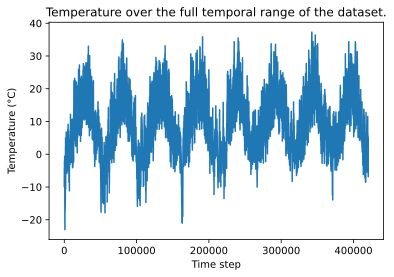

In [4]:
from matplotlib import pyplot as plt

temperature = raw_data['T (degC)'].values
plt.plot(temperature)
plt.xlabel("Time step")
plt.ylabel("Temperature (°C)")
plt.title("Temperature over the full temporal range of the dataset.");

Note that temperature is recorded every ten minutes. So 10 days correspond to  24 × 6 × 10 = 1440 time steps. On this plot, you can see daily periodicity, especially for the last 4 days. Also note that
this 10-day period must be coming from a fairly cold winter month. This example shows that periodicity occurs in multiple scales in the data (e.g. daily, weekly, or monthly cycles).

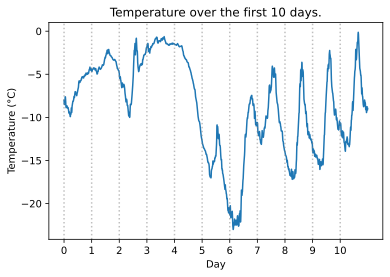

In [5]:
n_days = 10
plt.plot(temperature[:24*6*(n_days+1)]);

for i in range(n_days+1):
    plt.axvline(144*i, linestyle='dotted', alpha=0.5, color='gray')

plt.xticks(range(0, 144*(n_days+1), 144), labels=range(0, n_days+1))
plt.xlabel("Day")
plt.ylabel("Temperature (°C)")
plt.title(f"Temperature over the first {n_days} days.");

It turns out that predicting average temperature for the next month given a few months of past data is easy due to the reliable year-scale periodicity of the data. But looking at the data over a scale of days, the temperature looks a lot more chaotic. Is this timeseries predictable at a daily scale? 

**Problem.** Given data covering the previous five days and sampled once per hour, can we predict the temperature 24 hours in the future? 

### Preparing the data

For our modeling we will use a 50-25-25 temporal split of the dataset.

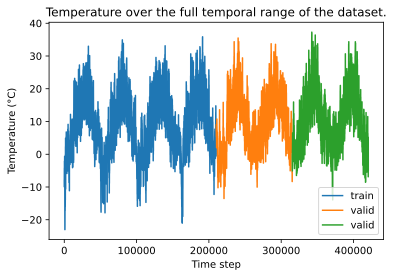

In [6]:
import matplotlib.pyplot as plt

T = len(raw_data)
train_end = int(0.5 * T)
valid_end = train_end + int(0.25 * T)

plt.plot(range(0, train_end), temperature[:train_end], label='train')
plt.plot(range(train_end, valid_end), temperature[train_end:valid_end], label='valid')
plt.plot(range(valid_end, T), temperature[valid_end:], label='valid')

plt.legend()
plt.xlabel("Time step")
plt.ylabel("Temperature (°C)")
plt.title("Temperature over the full temporal range of the dataset.");

First let's normalize the dataset so they are all on the same scale.

In [8]:
# learn statistics from train data
u = raw_data[:train_end].mean(axis=0)
s = raw_data[:train_end].std(axis=0)

# transform datasets using learned parameters
data = ((raw_data - u) / s)
data.head(3)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,0.913649,-1.920636,-1.974488,-1.866254,1.048015,-1.291316,-1.467152,-0.782343,-1.470122,-1.472032,2.124151,-0.730165,-0.779351,-0.281192
2009-01-01 00:20:00,0.919528,-1.965100,-2.018478,-1.919925,1.054028,-1.304472,-1.488855,-0.784440,-1.489114,-1.493462,2.172914,-0.932305,-0.886968,-0.469893
2009-01-01 00:30:00,0.914825,-1.976501,-2.029758,-1.924162,1.084097,-1.307103,-1.491266,-0.786537,-1.492912,-1.495843,2.183381,-1.277899,-1.261473,-0.056383


Next, we will create a `Dataset` object that yields batches of data from the past five days
along with a target temperature 24 hours in the future. Note that there is a lot of overlap in these data so that it doesn't make sense to explicitly allocate memory for every sample. Instead, we will generate samples using references to the original data stored in memory. We can use the Keras function `timeseries_dataset_from_array()` for this which works as follows:

In [20]:
from tensorflow.keras.utils import timeseries_dataset_from_array

# Predict next token
toy_ds = timeseries_dataset_from_array(
    data=range(13)[:-3], 
    targets=range(13)[3:], 
    sequence_length=3,
    batch_size=3, shuffle=True
)

print('batch  \t sequence \t target')
for b, (x, y) in enumerate(toy_ds):
    for i in range(len(x)):
        print(b, '\t', x[i].numpy(), '\t', y[i].numpy())

batch  	 sequence 	 target
0 	 [0 1 2] 	 3
0 	 [1 2 3] 	 4
0 	 [6 7 8] 	 9
1 	 [3 4 5] 	 6
1 	 [2 3 4] 	 5
1 	 [4 5 6] 	 7
2 	 [7 8 9] 	 10
2 	 [5 6 7] 	 8


Note that sequences in a batch are not necessarily contiguous. Now for the actual data:

In [51]:
sampling_rate = 6       # Get one sample every 6 data (i.e. 1 data point per hr)
sequence_length = 120   # 24 hrs * 5 days = 120 data points
delay = sampling_rate * (sequence_length + 24 - 1) # Amount of shift for target array
batch_size = 16

train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    range(len(raw_data))[:-delay],
    targets=range(len(raw_data))[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=0,
    end_index=train_end
)

In [69]:
next(iter(train_dataset))[1][0]

<tf.Tensor: shape=(), dtype=int32, numpy=858>

In [70]:
next(iter(train_dataset))[0][0].numpy().reshape(-1, 24)

array([[  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
         78,  84,  90,  96, 102, 108, 114, 120, 126, 132, 138],
       [144, 150, 156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216,
        222, 228, 234, 240, 246, 252, 258, 264, 270, 276, 282],
       [288, 294, 300, 306, 312, 318, 324, 330, 336, 342, 348, 354, 360,
        366, 372, 378, 384, 390, 396, 402, 408, 414, 420, 426],
       [432, 438, 444, 450, 456, 462, 468, 474, 480, 486, 492, 498, 504,
        510, 516, 522, 528, 534, 540, 546, 552, 558, 564, 570],
       [576, 582, 588, 594, 600, 606, 612, 618, 624, 630, 636, 642, 648,
        654, 660, 666, 672, 678, 684, 690, 696, 702, 708, 714]],
      dtype=int32)

In [91]:
6 * 24 * 6

864

In [82]:
sequence_length

120

In [ ]:
24

In [61]:
divmod((714 * 10), (60 * 24))

(4, 1380)

In [63]:
6 * 24

144

In [62]:
divmod(1380, 60)

(23, 0)

In [52]:
next(iter(train_dataset))[1]

<tf.Tensor: shape=(16,), dtype=int32, numpy=
array([858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870,
       871, 872, 873], dtype=int32)>